# Production Voronoi-Based Pu-Cl Cluster Analysis

This notebook implements the complete analysis pipeline for Pu-Cl cluster systems using Voronoi tessellation from OVITO.

## Overview

This analysis pipeline includes:
1. Voronoi tessellation using OVITO
2. Weighted coordination analysis
3. Shared-anion network construction
4. Oligomer characterization
5. Temporal stability analysis

See `spec.md` for detailed specification.


In [1]:
# All imports
import glob
import numpy as np
import matplotlib.pyplot as plt

# OVITO imports
from ovito.io import import_file

# Local utility imports
from utils import (
    get_pipeline_info,
    extract_particle_properties,
    # Phase 2: Voronoi Tessellation
    apply_voronoi_analysis,
    extract_voronoi_bonds,
    extract_voronoi_particle_properties,
    compute_voronoi_face_areas,
    perform_voronoi_tessellation,
    # Phase 3: Weighted Coordination Analysis
    compute_weighted_coordination_analysis,
    build_coordination_histograms,
    # Phase 4: Area Thresholding and Shared Anion Graph
    build_shared_anion_graph_from_voronoi,
    assign_cluster_ids_from_graph,
)

# Plotting imports
from plots import (
    setup_plot_style, 
    plot_coordination_histograms, 
    plot_weighted_coordination_comparison,
    plot_3d_cluster_component,  # Phase 4: 3D cluster visualization
    plot_unwrapped_3d_cluster_component,  # Phase 4: 3D cluster visualization with unwrapped coordinates
)


In [2]:
# %matplotlib ipympl -uncomment this line to enable interactive plotting

In [3]:
# Configure your input structure/trajectory file
input_path = '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.27/T1000K/dump.lammpstrj' # TODO: Set path, e.g., '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T900K/dump.lammpstrj'

# Analysis parameters (will be used in later phases)
MIN_AREA_PERCENT = 0.1  # Minimum area threshold as percent of total
USE_RADII = False  # Whether to use atomic radii for Voronoi tessellation

print("Configuration loaded")

Configuration loaded


## Data Loading

Load trajectory file and extract basic pipeline information.


In [4]:
# Load trajectory file using OVITO
if input_path is not None:
    # Load with OVITO pipeline
    pipeline = import_file(input_path, multiple_frames=True)
    print(f"Loaded trajectory with {pipeline.source.num_frames} frames")
    
    # Choose frame index (use last frame by default)
    frame = pipeline.source.num_frames - 1
    
    # Get basic pipeline information using utils
    info = get_pipeline_info(pipeline)
    print("\nPipeline Information:")
    print(f"  Number of frames: {info['num_frames']}")
    print(f"  Number of particles: {info['num_particles']}")
    print(f"  Species: {info['species']}")
    
    # Display cell information from utils
    if info['cell_info']:
        cell_info = info['cell_info']
        print("\nCell Information:")
        if cell_info.get('matrix') is not None:
            print("  Cell matrix:")
            print(np.array(cell_info['matrix']))
        print(f"  PBC: {cell_info.get('pbc', 'N/A')}")
    
    # Set up standardized plotting style
    setup_plot_style()
    print("\nStandardized plotting style configured")
else:
    print("input_path not set. Please configure the trajectory file path above.")
    pipeline = None
    frame = None


Loaded trajectory with 14171 frames

Pipeline Information:
  Number of frames: 14171
  Number of particles: 3584
  Species: ['Cl', 'Na', 'Pu']

Cell Information:
  Cell matrix:
[[47.94052381  0.          0.          0.05055929]
 [ 0.         47.94052381  0.          0.05055929]
 [ 0.          0.         47.94052381  0.05055929]]
  PBC: (True, True, True)

Standardized plotting style configured


## Basic Pipeline Info Extraction

Extract and display particle properties from a specific frame.


In [5]:
# Extract data from chosen frame
if pipeline is not None and frame is not None:
    frame_data = pipeline.compute(frame)
    properties = extract_particle_properties(frame_data)
    
    print(f"Frame {frame} Properties:")
    print(f"  Positions shape: {properties['positions'].shape if properties['positions'] is not None else 'N/A'}")
    print(f"  Species shape: {properties['species'].shape if properties['species'] is not None else 'N/A'}")
    if properties['species'] is not None:
        unique_species = np.unique(properties['species'])
        print(f"  Unique species in frame: {unique_species}")
    print(f"  Cell matrix shape: {properties['cell_matrix'].shape if properties['cell_matrix'] is not None else 'N/A'}")
    print(f"  Periodic boundary conditions: {properties['pbc']}")
else:
    print("Pipeline not loaded. Please load a trajectory file first.")

Frame 14170 Properties:
  Positions shape: (3584, 3)
  Species shape: (3584,)
  Unique species in frame: ['Cl' 'Na' 'Pu']
  Cell matrix shape: (3, 4)
  Periodic boundary conditions: (True, True, True)


## Phase 2: Voronoi Tessellation

Apply VoronoiAnalysisModifier with generate_bonds=True and extract results.


In [6]:
# Perform Voronoi tessellation

voronoi_results = perform_voronoi_tessellation(
    pipeline=pipeline,
    frame=frame,
    use_radii=USE_RADII,
    edge_threshold=0.0,
    compute_surface_mesh=False,
)

# Extract results
data = voronoi_results['data']
bonds = voronoi_results['bonds']
particle_props = voronoi_results['particle_properties']
face_areas = voronoi_results['face_areas']


In [7]:
print(face_areas)

[4.84987287 0.18711997 9.38557883 ... 0.74120721 4.42113363 6.50210591]


In [8]:
print('face_areas',len(face_areas),'bonds',len(bonds['pairs']))

face_areas 27458 bonds 27458


## Phase 3: Weighted Coordination Analysis

Compute area-weighted (CN_A) and solid-angle-weighted (CN_Ω) coordination numbers, and build coordination histograms for Pu with different neighbor types.


In [9]:
# Compute weighted coordination analysis (includes topological, area-weighted, and solid-angle-weighted)
coordination_results = compute_weighted_coordination_analysis(
    data=data,
    bonds=bonds,
    particle_properties=particle_props,
    face_areas=face_areas,
    center_species='Pu'
)

# Extract results
cn_topological_all = coordination_results['cn_topological_all']
cn_a_all = coordination_results['cn_a_all']
cn_omega_all = coordination_results['cn_omega_all']
histograms = coordination_results['histograms']
positions = coordination_results['positions']
species = coordination_results['species']
pairs = bonds['pairs']

print("Weighted coordination analysis completed")
print(f"  Number of Pu atoms analyzed: {len(cn_a_all['atom_indices'])}")
print(f"\nTopological CN (all neighbors) - mean: {np.mean(cn_topological_all['cn_values']):.3f}, std: {np.std(cn_topological_all['cn_values']):.3f}")
print(f"CN_A (all neighbors) - mean: {np.mean(cn_a_all['cn_values']):.3f}, std: {np.std(cn_a_all['cn_values']):.3f}")
print(f"CN_Ω (all neighbors) - mean: {np.mean(cn_omega_all['cn_values']):.3f}, std: {np.std(cn_omega_all['cn_values']):.3f}")


Weighted coordination analysis completed
  Number of Pu atoms analyzed: 384

Topological CN (all neighbors) - mean: 11.208, std: 1.618
CN_A (all neighbors) - mean: 6.615, std: 1.383
CN_Ω (all neighbors) - mean: 5.417, std: 1.490


In [10]:
# # Build histograms with different coordination types
# histograms_topological = build_coordination_histograms(
#     pairs, species, center_species='Pu', coordination_type='topological'
# )

# histograms_area = build_coordination_histograms(
#     pairs, species, center_species='Pu', coordination_type='area',
#     positions=positions, face_areas=face_areas
# )

# histograms_solid_angle = build_coordination_histograms(
#     pairs, species, center_species='Pu', coordination_type='solid_angle',
#     positions=positions, face_areas=face_areas
# )

# print("Histograms built for all coordination types")

In [11]:
# # Visualize coordination histograms - Topological
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# plot_coordination_histograms(histograms_area, ax=ax, title='Pu Coordination Histograms')
# plt.tight_layout()
# plt.show()


In [12]:
# # Visualize CN_A vs CN_Ω comparison with statistics
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot_weighted_coordination_comparison(
#     cn_a_all, cn_omega_all, species, ax=ax,
#     x_label='CN_A (Area-weighted)', y_label='CN_Ω (Solid-angle-weighted)',
#     title='Area-weighted vs Solid-angle-weighted Coordination'
# )
# plt.tight_layout()
# plt.show()


## Phase 4: Area Thresholding and Shared Anion Graph

Threshold Voronoi faces by area percent, build shared anion graph with Pu and Cl nodes, and assign cluster IDs to connected components.


In [13]:
# Perform second Voronoi tessellation with area threshold for graph construction
# This filters faces atom-wise using OVITO's relative_face_threshold parameter
voronoi_results_filtered = perform_voronoi_tessellation(
    pipeline=pipeline,
    frame=frame,
    use_radii=USE_RADII,
    edge_threshold=0.0,
    compute_surface_mesh=False,
    relative_face_threshold=MIN_AREA_PERCENT,  # Apply threshold during tessellation
)

# Extract filtered results
filtered_bonds = voronoi_results_filtered['bonds']
filtered_pairs = filtered_bonds['pairs']  # Already filtered by OVITO
filtered_face_areas = voronoi_results_filtered['face_areas']  # Already filtered

print("Area Thresholding Results (using OVITO relative_face_threshold):")
print(f"  Original number of faces (from Phase 2): {len(pairs)}")
print(f"  Filtered number of faces (from Phase 4): {len(filtered_pairs)}")
print(f"  Faces removed: {len(pairs) - len(filtered_pairs)} ({100.0 * (len(pairs) - len(filtered_pairs)) / len(pairs):.2f}%)")
if len(filtered_pairs) > 0:
    print(f"  Average face area (original): {np.mean(face_areas):.4f}")
    print(f"  Average face area (filtered): {np.mean(filtered_face_areas):.4f}")


Area Thresholding Results (using OVITO relative_face_threshold):
  Original number of faces (from Phase 2): 27458
  Filtered number of faces (from Phase 4): 7777
  Faces removed: 19681 (71.68%)
  Average face area (original): 3.5927
  Average face area (filtered): 3.6026


In [14]:
# # Compute weighted coordination analysis (includes topological, area-weighted, and solid-angle-weighted)
# coordination_results_filtered = compute_weighted_coordination_analysis(
#     data=data,
#     bonds=filtered_bonds,
#     particle_properties=particle_props,
#     face_areas=filtered_face_areas,
#     center_species='Pu'
# )

# # Extract results
# cn_topological_all_filtered = coordination_results_filtered['cn_topological_all']
# cn_a_all_filtered = coordination_results_filtered['cn_a_all']
# cn_omega_all_filtered = coordination_results_filtered['cn_omega_all']
# histograms_filtered = coordination_results_filtered['histograms']
# positions_filtered = coordination_results_filtered['positions']
# species_filtered = coordination_results_filtered['species']
# pairs_filtered = filtered_bonds['pairs']

# print("Weighted coordination analysis completed")
# print(f"  Number of Pu atoms analyzed: {len(cn_a_all_filtered['atom_indices'])}")
# print(f"\nTopological CN (all neighbors) - mean: {np.mean(cn_topological_all_filtered['cn_values']):.3f}, std: {np.std(cn_topological_all_filtered['cn_values']):.3f}")
# print(f"CN_A (all neighbors) - mean: {np.mean(cn_a_all_filtered['cn_values']):.3f}, std: {np.std(cn_a_all_filtered['cn_values']):.3f}")
# print(f"CN_Ω (all neighbors) - mean: {np.mean(cn_omega_all_filtered['cn_values']):.3f}, std: {np.std(cn_omega_all_filtered['cn_values']):.3f}")


In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# plot_coordination_histograms(histograms_filtered, ax=ax, title='Pu Coordination Histograms')
# plt.tight_layout()
# plt.show()

In [16]:
# Build shared anion graph from Voronoi tessellation
graph = build_shared_anion_graph_from_voronoi(
    pairs=filtered_pairs,
    face_areas=filtered_face_areas,
    positions=positions,
    species=species,
    cation='Pu',
    anion='Cl',
)

print("Graph Construction Results:")
print(f"  Number of nodes: {graph.number_of_nodes()}")
print(f"  Number of edges: {graph.number_of_edges()}")

# Count nodes by species
pu_nodes = [n for n in graph.nodes() if graph.nodes[n]['species'] == 'Pu']
cl_nodes = [n for n in graph.nodes() if graph.nodes[n]['species'] == 'Cl']
print(f"  Pu nodes: {len(pu_nodes)}")
print(f"  Cl nodes: {len(cl_nodes)}")

# Count edges by type
pu_pu_edges = sum(1 for u, v in graph.edges() if graph.nodes[u]['species'] == 'Pu' and graph.nodes[v]['species'] == 'Pu')
pu_cl_edges = sum(1 for u, v in graph.edges() if (graph.nodes[u]['species'] == 'Pu' and graph.nodes[v]['species'] == 'Cl') or 
                                                   (graph.nodes[u]['species'] == 'Cl' and graph.nodes[v]['species'] == 'Pu'))
cl_cl_edges = sum(1 for u, v in graph.edges() if graph.nodes[u]['species'] == 'Cl' and graph.nodes[v]['species'] == 'Cl')
print(f"  Pu-Pu edges: {pu_pu_edges}")
print(f"  Pu-Cl edges: {pu_cl_edges}")
print(f"  Cl-Cl edges: {cl_cl_edges}")


Graph Construction Results:
  Number of nodes: 2560
  Number of edges: 2158
  Pu nodes: 384
  Cl nodes: 2176
  Pu-Pu edges: 0
  Pu-Cl edges: 2158
  Cl-Cl edges: 0


In [17]:
# Assign cluster IDs from graph
num_atoms = len(species)
cluster_ids, cluster_sizes = assign_cluster_ids_from_graph(
    graph=graph,
    num_atoms=num_atoms,
    species=species,
)

print("Cluster Assignment Results:")
print(f"  Number of clusters: {len(cluster_sizes)}")
print(f"  Total atoms in clusters: {np.sum(cluster_sizes)}")
print(f"  Unclustered atoms: {np.sum(cluster_ids == -1)}")

if len(cluster_sizes) > 0:
    print(f"\nCluster size statistics:")
    print(f"  Largest cluster size: {np.max(cluster_sizes)}")
    print(f"  Smallest cluster size: {np.min(cluster_sizes)}")
    print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
    



Cluster Assignment Results:
  Number of clusters: 461
  Total atoms in clusters: 2560
  Unclustered atoms: 1024

Cluster size statistics:
  Largest cluster size: 237
  Smallest cluster size: 1
  Mean cluster size: 5.55
  Median cluster size: 1.00


Plotting cluster 0 (largest cluster)
  Cluster size: 237 atoms


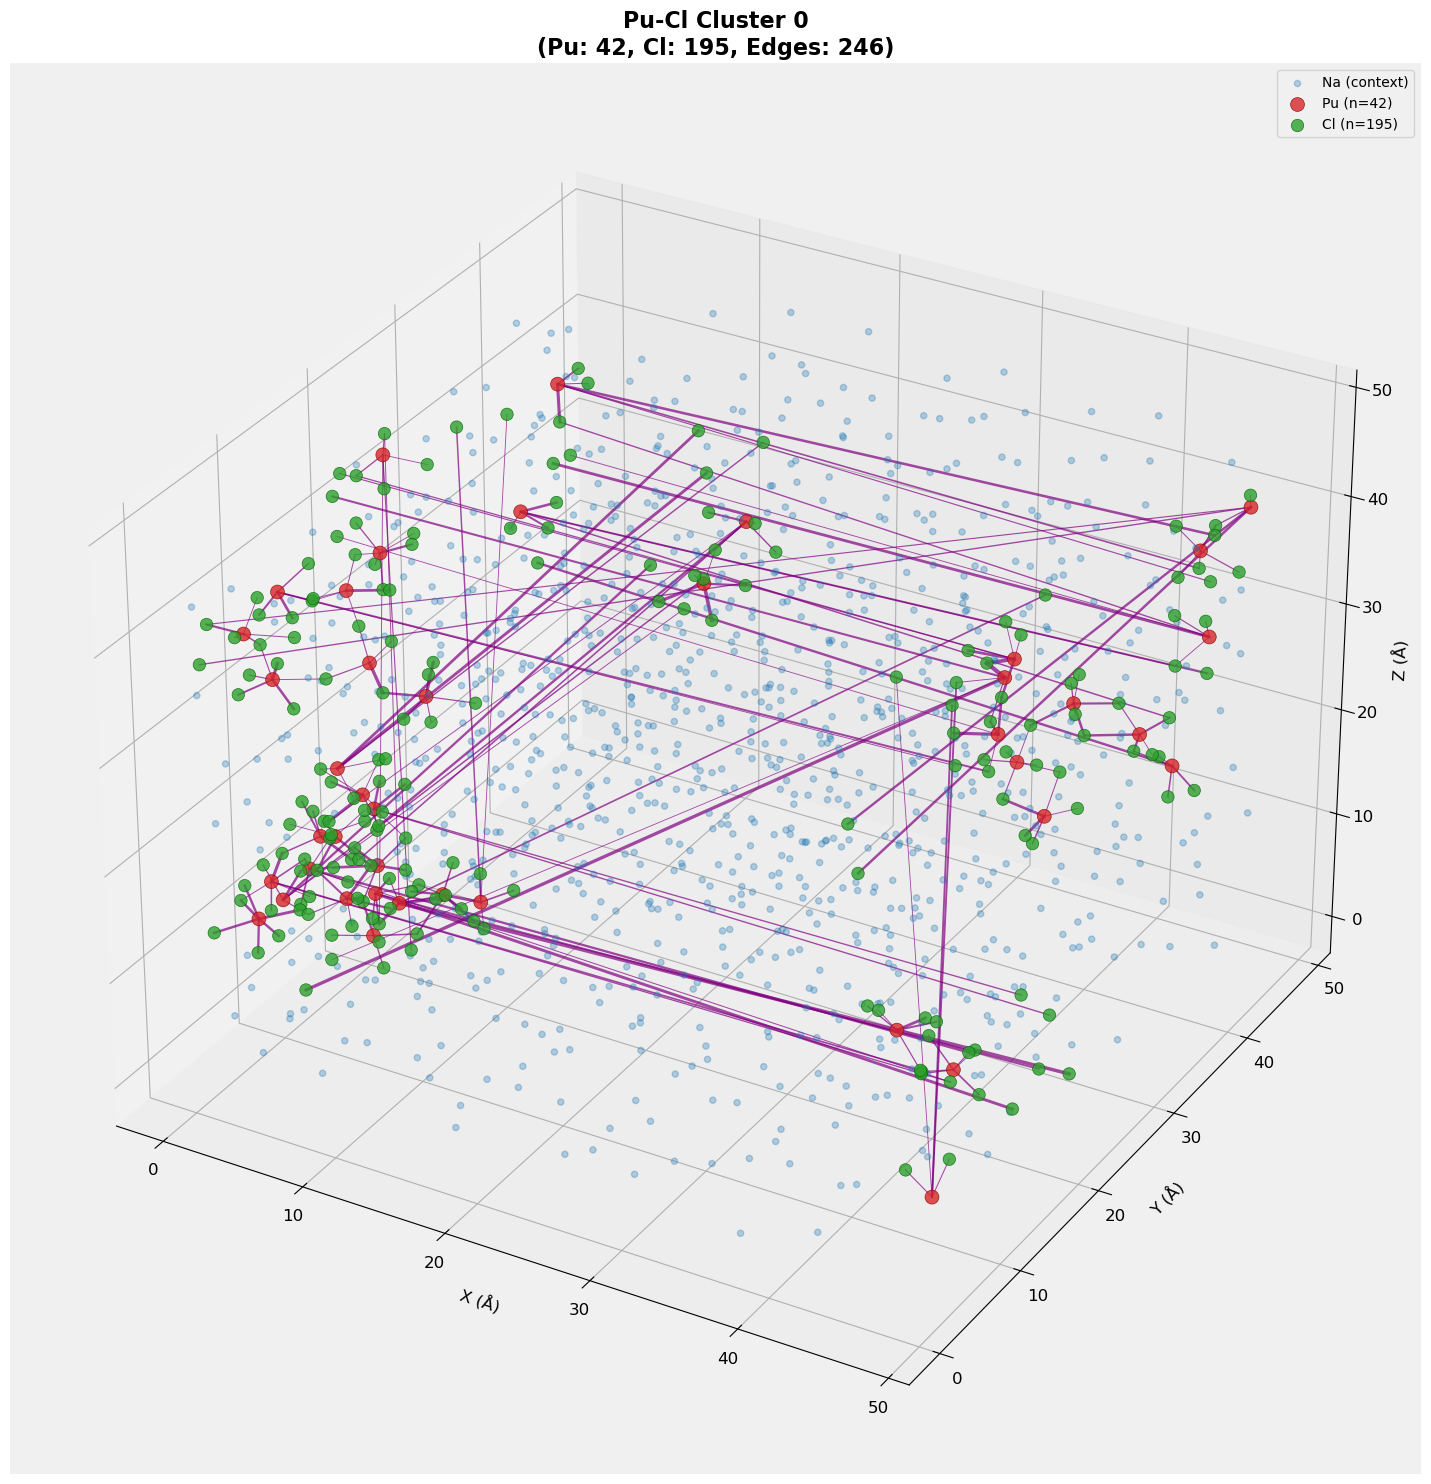

In [18]:
# Plot a specific cluster component
# Change cluster_id to visualize different clusters
# Cluster IDs range from 0 to (number_of_clusters - 1)

if len(cluster_sizes) > 0:
    # Plot the largest cluster (cluster_id = 0, since clusters are sorted by size)
    largest_cluster_id = 0
    
    print(f"Plotting cluster {largest_cluster_id} (largest cluster)")
    print(f"  Cluster size: {cluster_sizes[largest_cluster_id]} atoms")
    
    plot_3d_cluster_component(
        graph=graph,
        cluster_ids=cluster_ids,
        cluster_id=largest_cluster_id,
        positions=positions,
        species=species,
        cation='Pu',  # Can be changed to 'Ce' or other cation
        anion='Cl',
        show_na_context=True,  # Show Na atoms as background
        show_edges=True,  # Show edges between atoms
    )
else:
    print("No clusters found to plot")


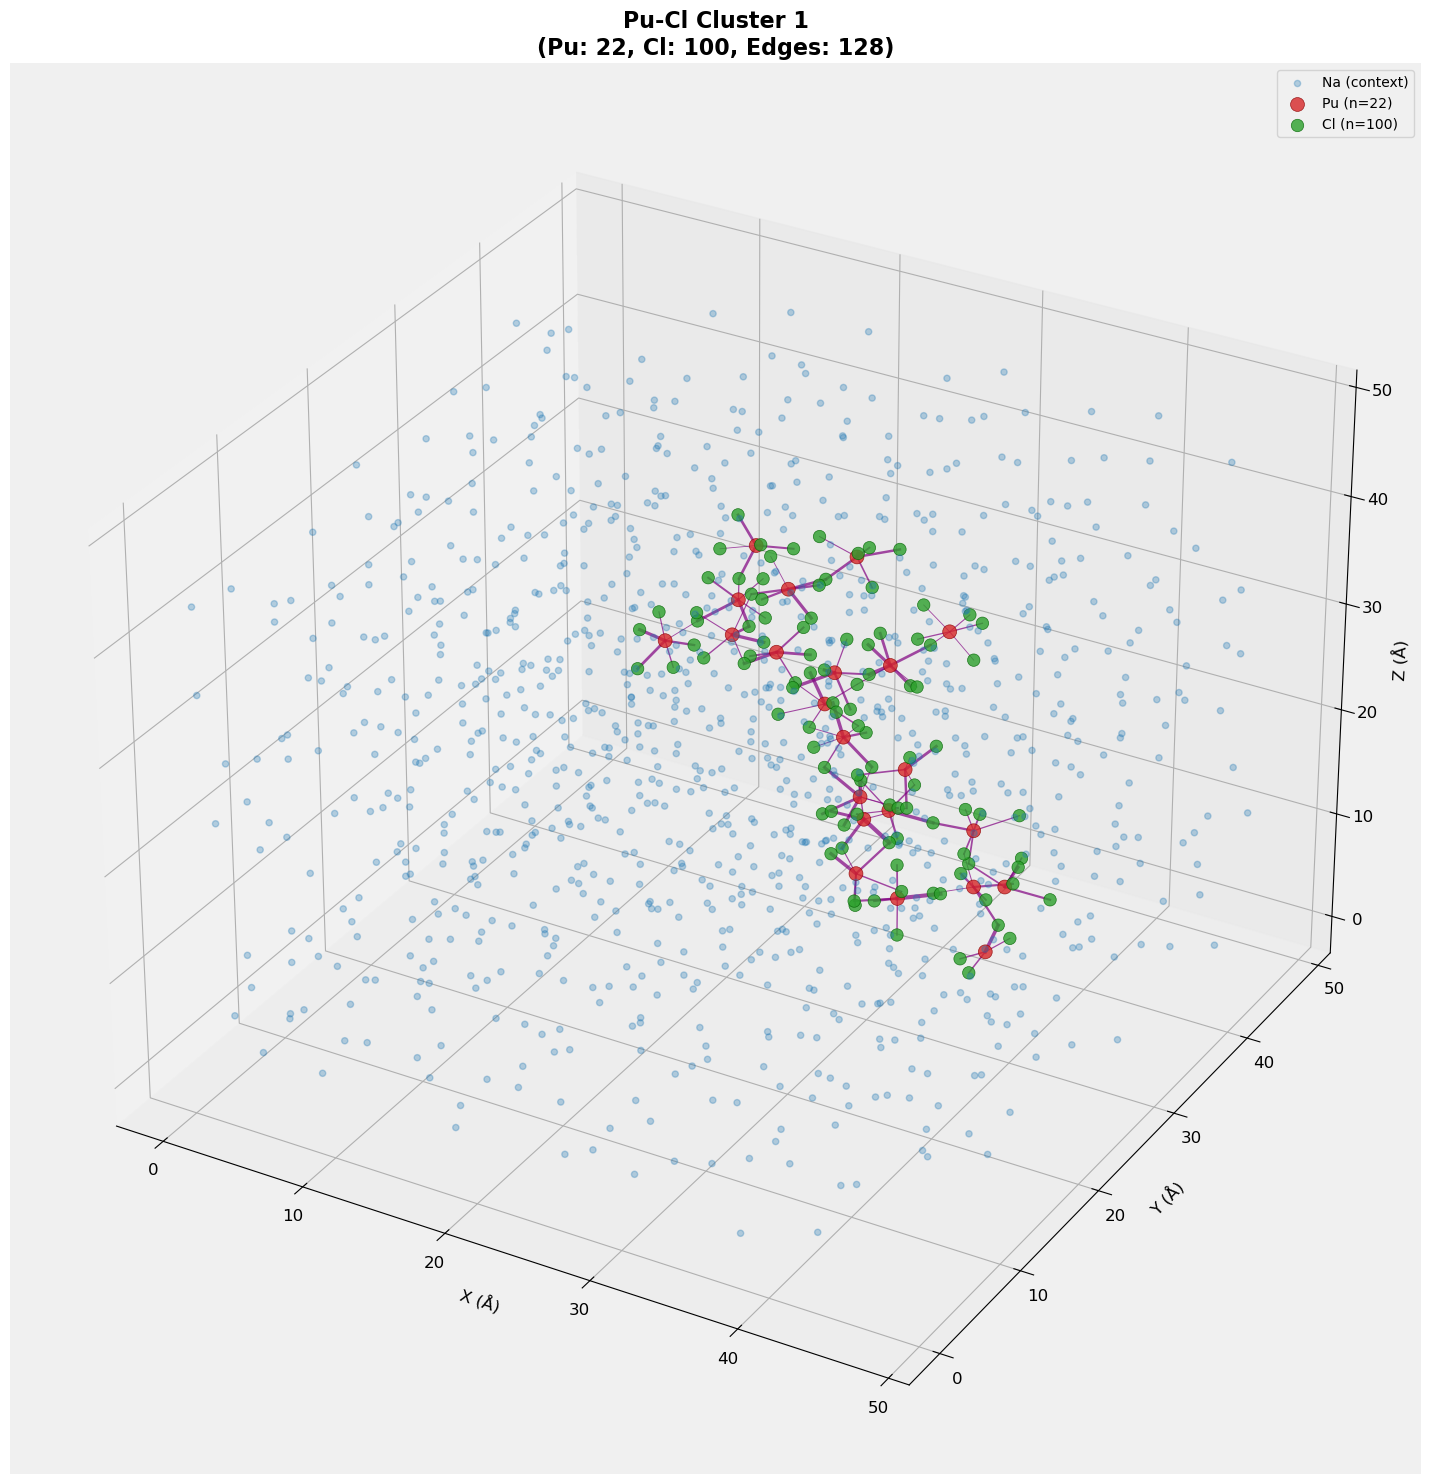

In [19]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=1,
    positions=positions,
    species=species,
    cation='Pu',  # Can be changed to 'Ce' or other cation
    anion='Cl',
    show_na_context=True,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
)



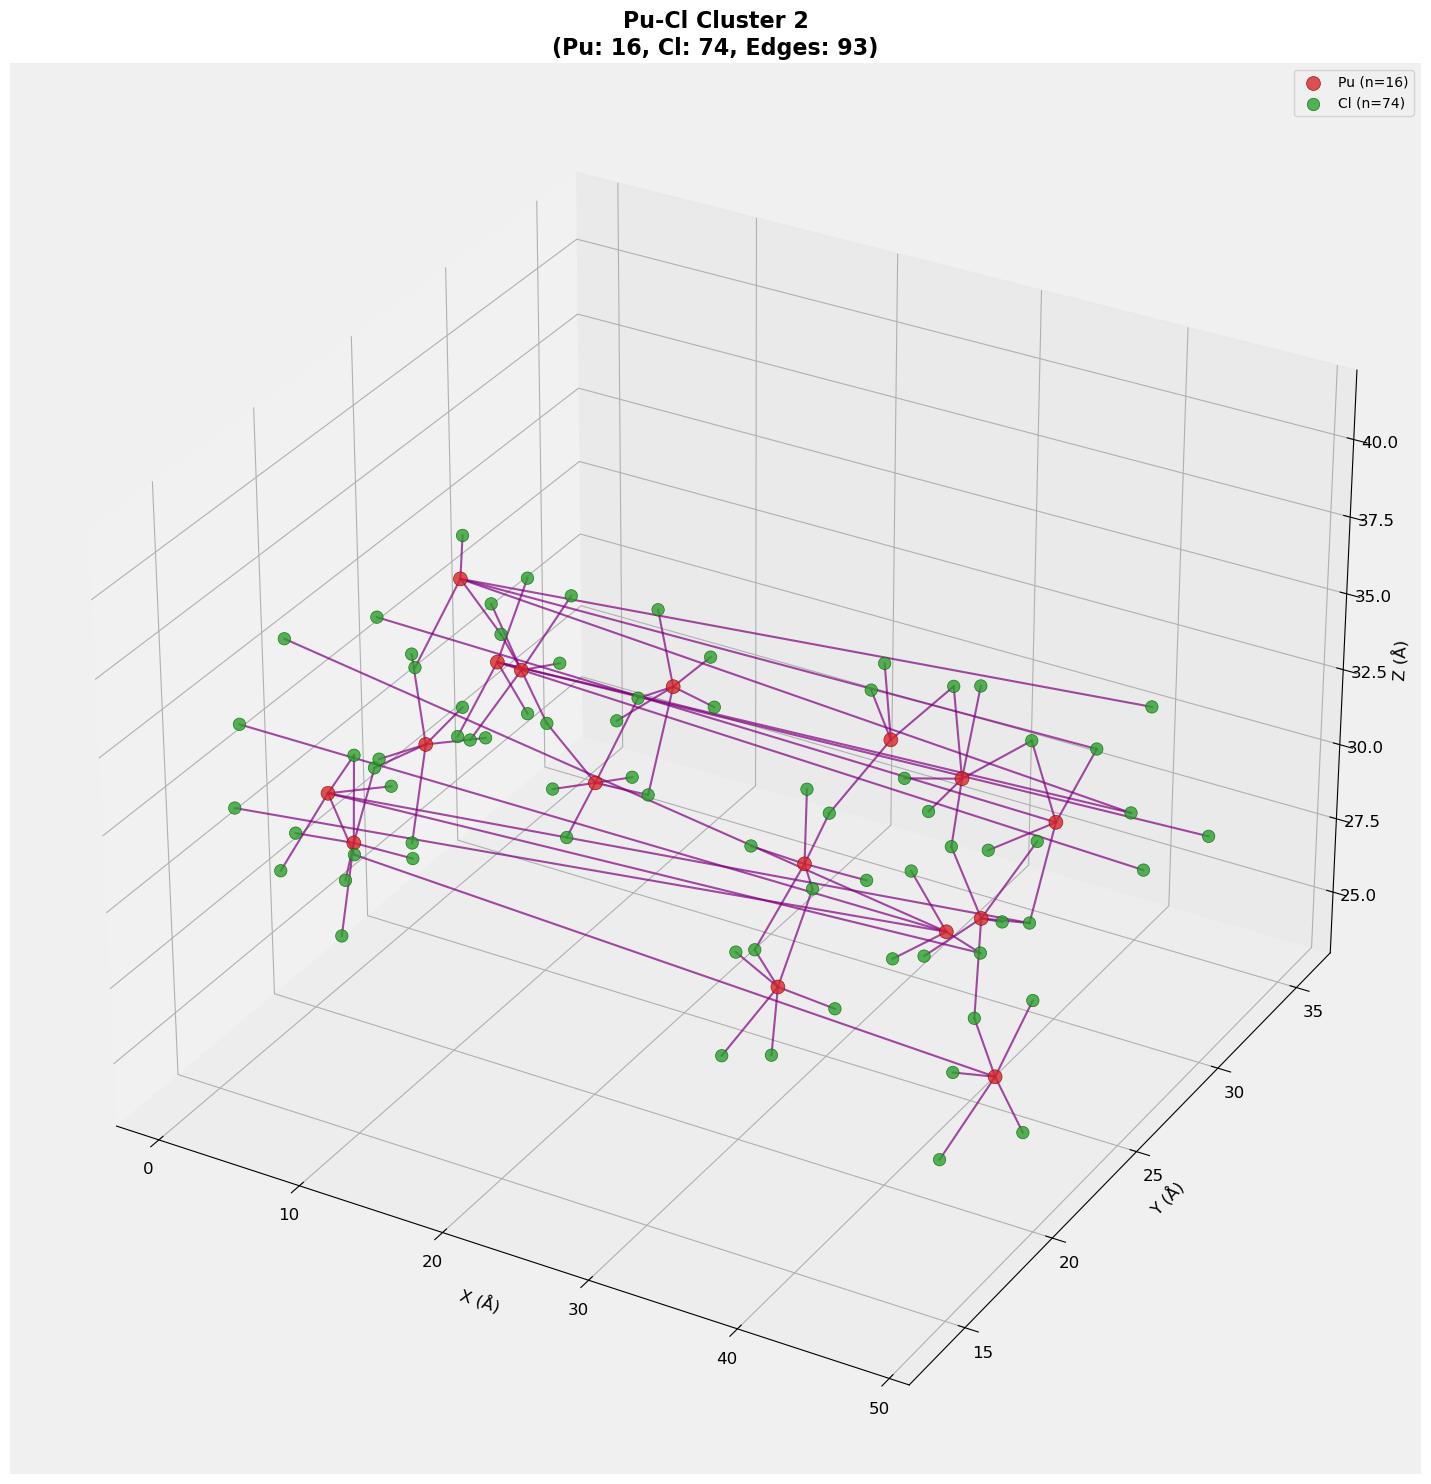

In [20]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=2,
    positions=positions,
    species=species,
    cation='Pu',  # Can be changed to 'Ce' or other cation
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
    scale_edge_width_by_area=False,
)



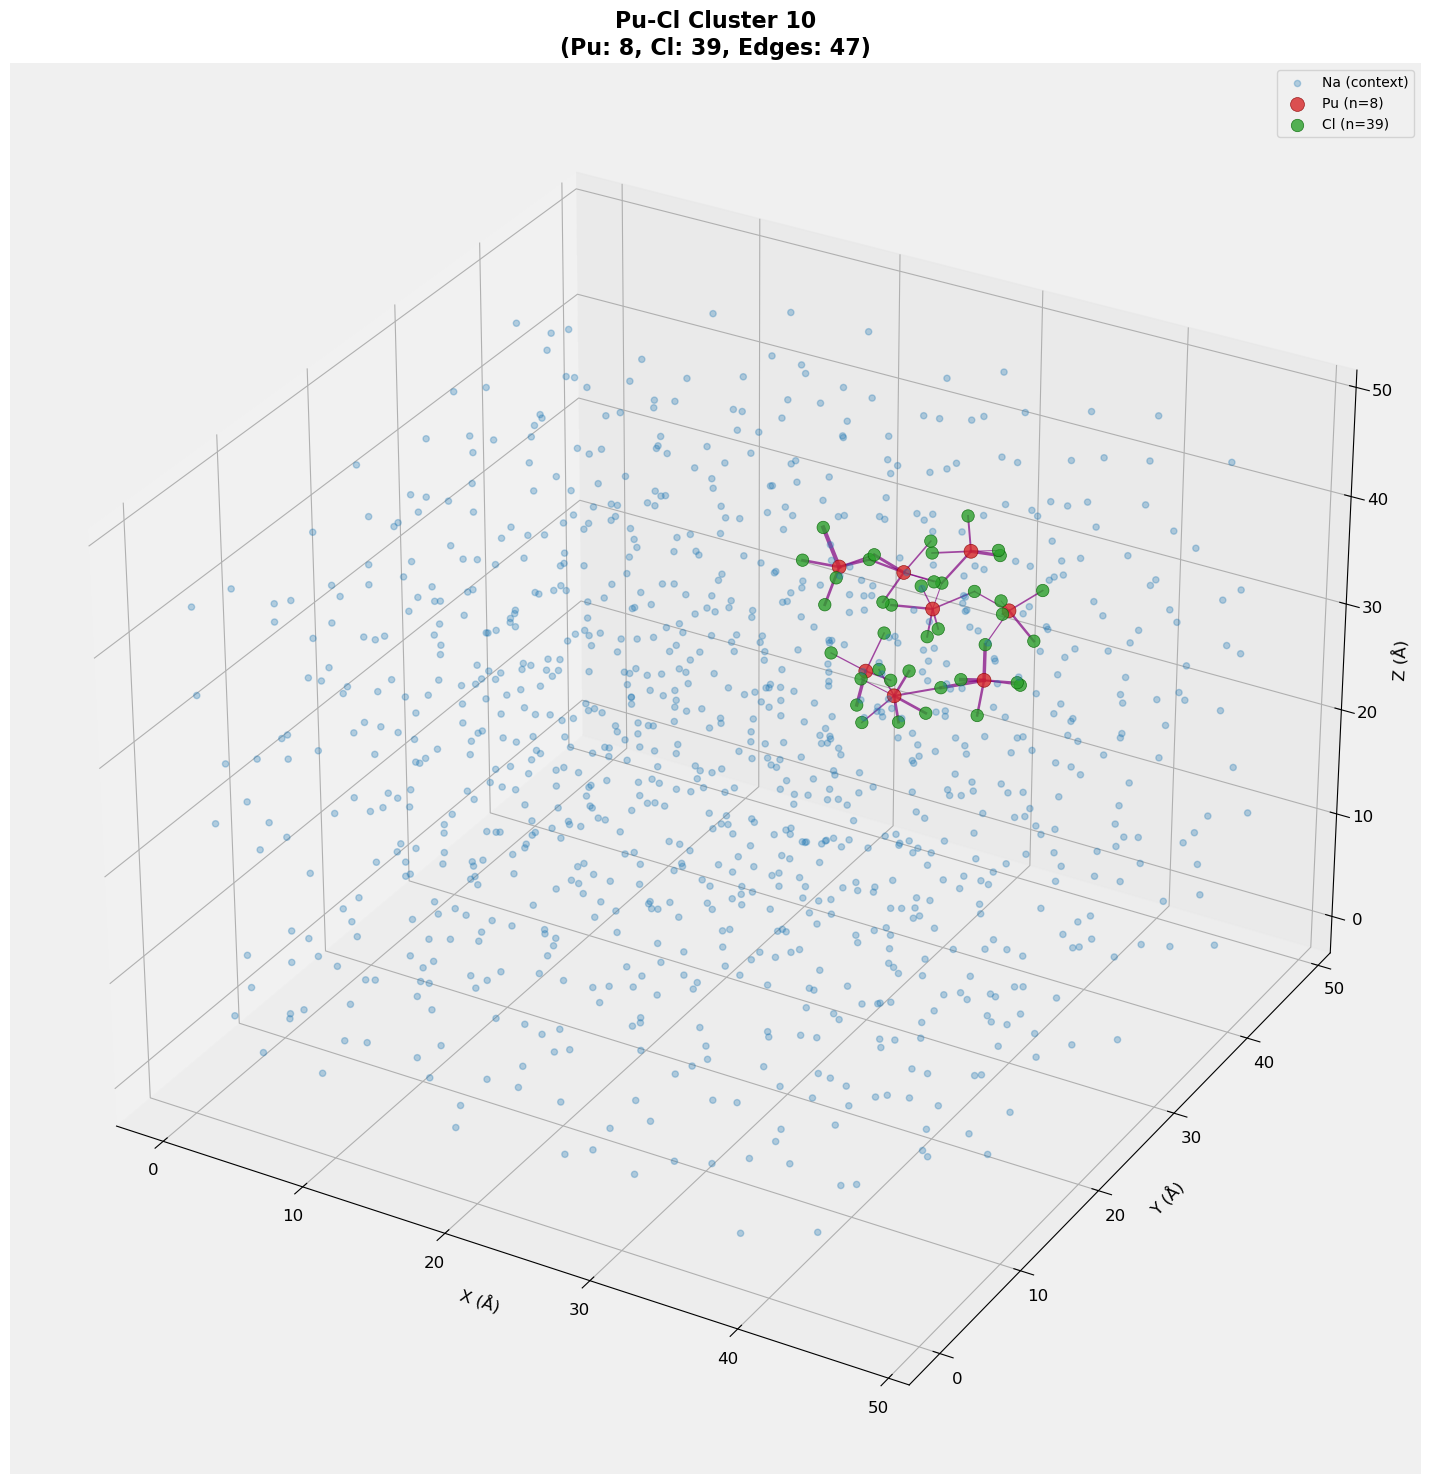

In [21]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=10,
    positions=positions,
    species=species,
    cation='Pu',  # Can be changed to 'Ce' or other cation
    anion='Cl',
    show_na_context=True,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
)



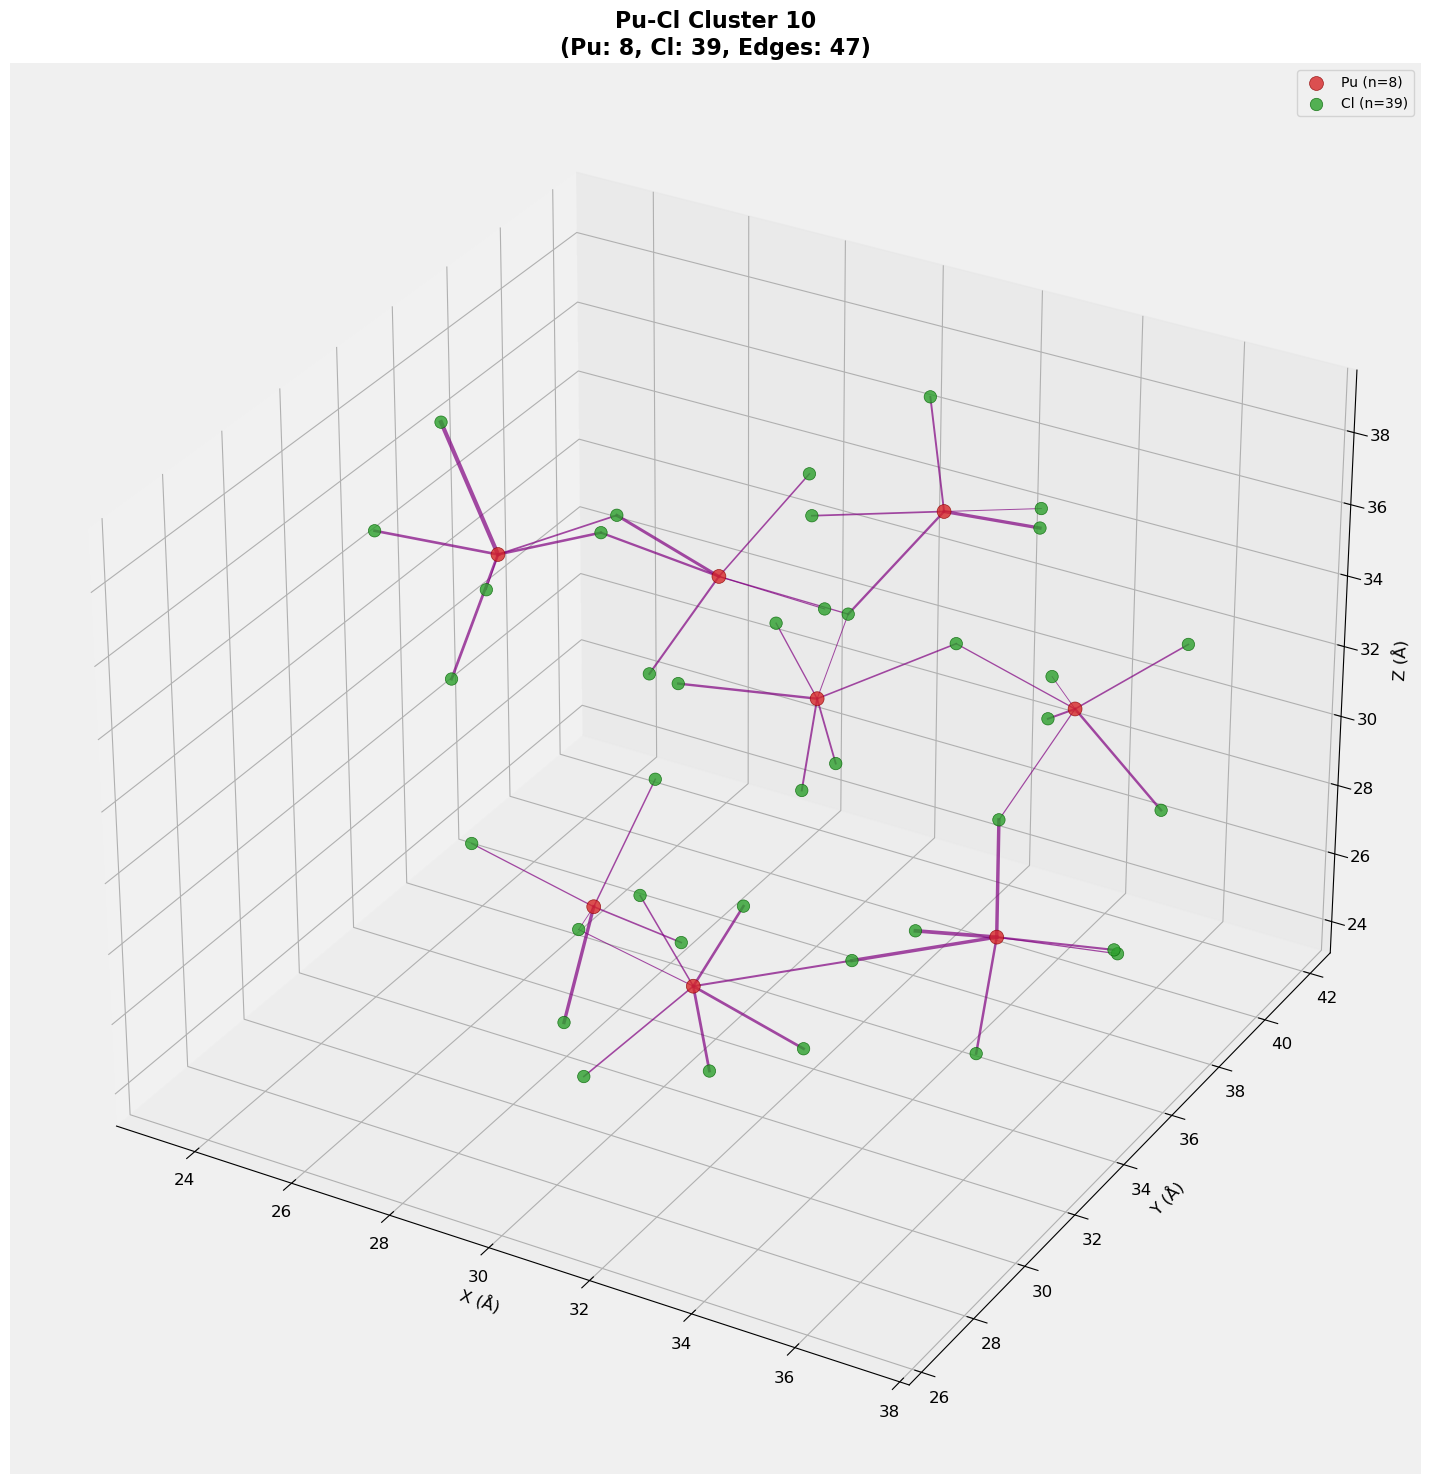

In [22]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=10,
    positions=positions,
    species=species,
    cation='Pu',  # Can be changed to 'Ce' or other cation
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
)



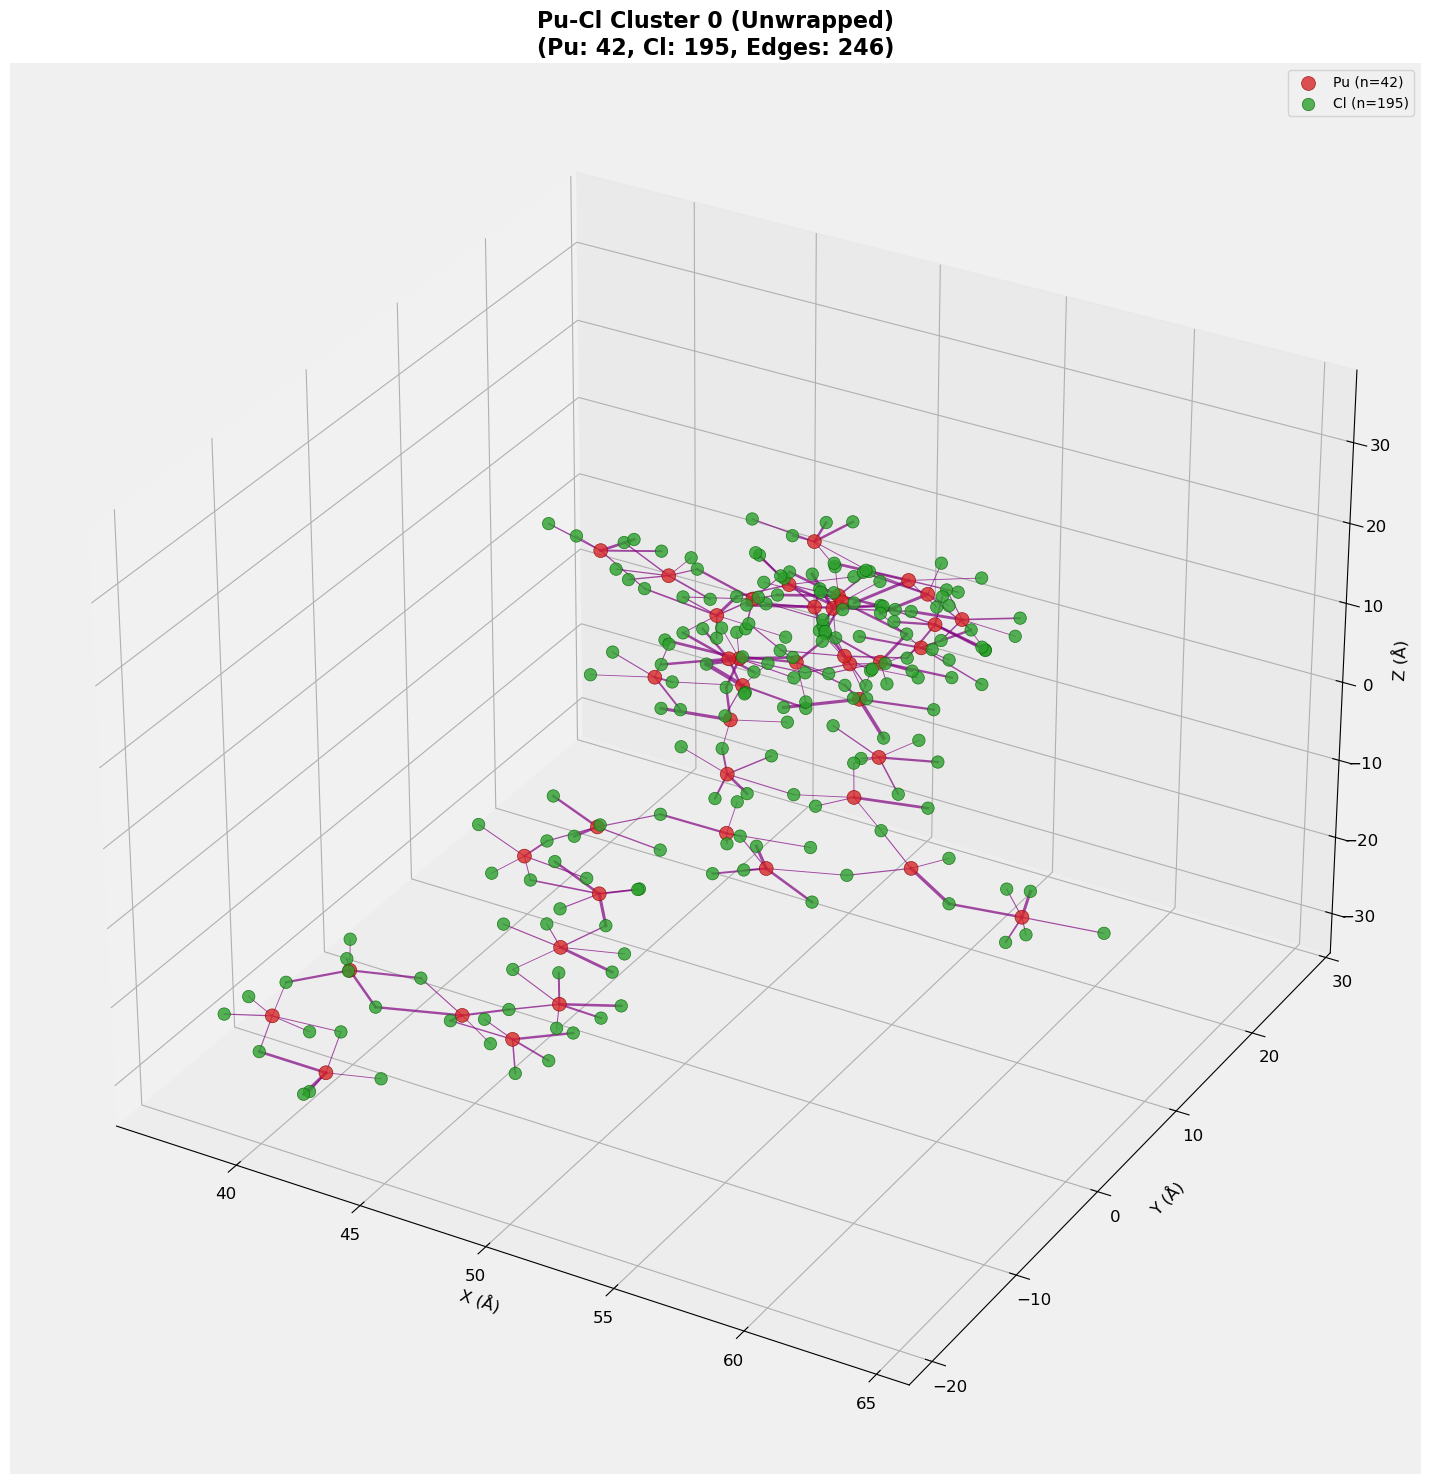

In [23]:
plot_unwrapped_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=0,
    positions=positions,
    species=species,
    cell_matrix=properties['cell_matrix'],  # Required for unwrapping
    cation='Pu',
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background (wrapped coordinates)
    show_edges=True,  # Show edges between atoms (unwrapped coordinates)
)

In [24]:
# TODO: Add unwrapping of clusters -